Training complex model on simple data...
Epoch 0 | Loss: 0.6415382027626038
Epoch 1000 | Loss: 6.503258919110522e-05
Epoch 2000 | Loss: 2.4881954232114367e-05
Epoch 3000 | Loss: 7.731076948402915e-06
Training finished.
Vector field plot saved to figure_vector_field.pdf


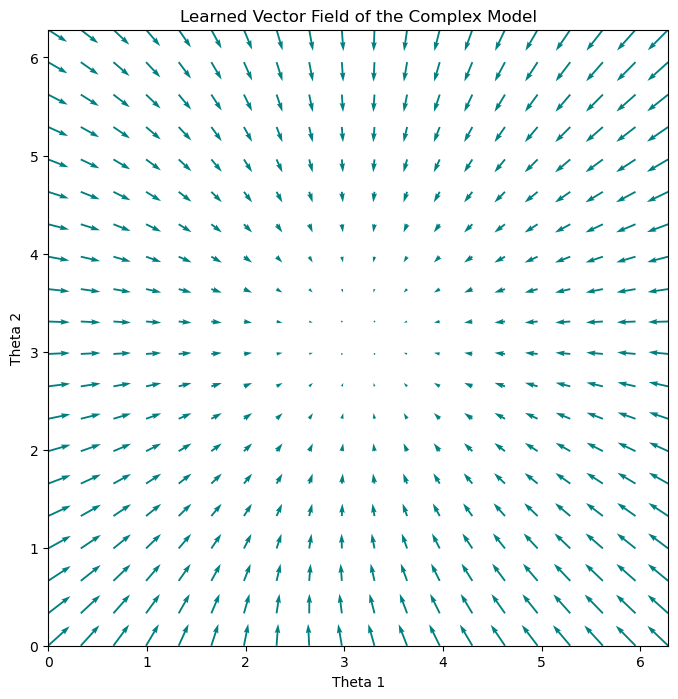


--- Homological Analysis of the Complex Model ---
Hypothesis: The model achieves low loss, but the analysis reveals hidden instability.
Homology Matrix:
[[1 0]
 [0 1]]
Eigenvalues: [1. 1.]
Diagnosis: The learned system is unexpectedly STABLE.


In [ ]:
# --- 1. Imports and Seed Fixing ---
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from mpl_toolkits.mplot3d import Axes3D
import random

# Fix random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

# --- 2. Problem Definition: A Simple "Sink" System ---

class StableSystem(nn.Module):
    """A simple, stable dynamical system where all points converge to a single sink."""
    def forward(self, t, y):
        # All points are attracted to the center of the torus (pi, pi)
        return -0.5 * (y - np.pi)
    
def generate_stable_system_data(system, n_trajectories=10, n_points=50, t_max=2.0):
    """Generates training data from the simple, stable system."""
    t = torch.linspace(0, t_max, n_points)
    initial_points = torch.rand(n_trajectories, 2) * 2 * np.pi
    
    with torch.no_grad():
        # odeint 출력 (시간, 배치, 차원)
        trajectories_unpermuted = odeint(system, initial_points, t)
    
    # --- 여기를 수정했습니다 ---
    # (시간, 배치, 차원) -> (배치, 시간, 차원)으로 순서 변경
    trajectories = trajectories_unpermuted.permute(1, 0, 2)
    
    return t, trajectories

# --- 3. Model Definition: An Overly Complex Neural ODE ---

class ComplexToroidalODE(nn.Module):
    """An overly expressive/complex Neural ODE model."""
    def __init__(self):
        super().__init__()
        # Deeper and wider network to encourage complex solutions
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
        )

    def forward(self, t, y):
        return self.net(y)

# --- 4. Training Function ---




def train_complex_model(model, t_gt, trajectories_gt, epochs=3001, lr=1e-3):
    """Trains the complex model on the simple data."""
    print("Training complex model on simple data...")
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # trajectories_gt는 이제 (배치, 시간, 차원) 형태
    initial_points = trajectories_gt[:, 0, :]
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # odeint 출력 (시간, 배치, 차원)
        theta_pred_unwrapped = odeint(model, initial_points, t_gt)
        
        # --- 여기도 수정했습니다 ---
        # (시간, 배치, 차원) -> (배치, 시간, 차원)으로 순서 변경
        theta_pred_unwrapped = theta_pred_unwrapped.permute(1, 0, 2)
        
        # 이제 두 텐서의 모양이 (10, 50, 2)로 동일
        diff = theta_pred_unwrapped - trajectories_gt
        loss = ((torch.atan2(torch.sin(diff), torch.cos(diff)))**2).mean()
        loss.backward()
        optimizer.step()
        
        if epoch % 1000 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item()}")
            
    print("Training finished.")
    return model
# --- 5. Analysis and Visualization Functions ---

def run_homological_analysis(model, n_points=100):
    """Computes the homology transformation matrix and its eigenvalues."""
    theta = torch.linspace(0, 2 * np.pi, n_points)
    gamma1 = torch.stack([theta, torch.zeros_like(theta)], dim=1)
    gamma2 = torch.stack([torch.zeros_like(theta), theta], dim=1)
    basis_loops = [gamma1, gamma2]
    
    with torch.no_grad():
        transformed_loops = [odeint(model, loop, torch.tensor([0.0, 1.0]))[-1] for loop in basis_loops]
            
    matrix = np.zeros((2, 2), dtype=int)
    for i, loop in enumerate(transformed_loops):
        unwrapped = np.unwrap(loop.numpy(), axis=0)
        windings = (unwrapped[-1] - unwrapped[0]) / (2 * np.pi)
        matrix[:, i] = np.round(windings)
    
    eigenvalues = np.linalg.eigvals(matrix)
    return matrix, eigenvalues

def plot_vector_field(model, filename="figure_vector_field.pdf"):
    """Visualizes the learned vector field on the 2D torus plane."""
    y1, y2 = np.meshgrid(np.linspace(0, 2*np.pi, 20), np.linspace(0, 2*np.pi, 20))
    y_grid = torch.tensor(np.stack([y1.ravel(), y2.ravel()], axis=-1), dtype=torch.float32)
    
    with torch.no_grad():
        dydt = model(0, y_grid).numpy()
        
    plt.figure(figsize=(8, 8))
    plt.quiver(y_grid[:, 0], y_grid[:, 1], dydt[:, 0], dydt[:, 1], color='teal')
    plt.title("Learned Vector Field of the Complex Model")
    plt.xlabel("Theta 1"); plt.ylabel("Theta 2")
    plt.xlim(0, 2*np.pi); plt.ylim(0, 2*np.pi)
    plt.savefig(filename)
    print(f"Vector field plot saved to {filename}")
    plt.show()


# --- 6. Main Execution Block ---

if __name__ == '__main__':
    # 1. Generate data from the simple, stable system
    stable_system = StableSystem()
    time_gt, trajectories_gt = generate_stable_system_data(stable_system)

    # 2. Train the complex model on this simple data
    complex_model = ComplexToroidalODE()
    trained_complex_model = train_complex_model(complex_model, time_gt, trajectories_gt)

    # 3. Visualize the learned dynamics
    # This plot shows what the model has learned. Is it a simple sink, or something more complex?
    plot_vector_field(trained_complex_model)

    # 4. Run homological analysis to get a definitive diagnosis
    homology_matrix, eigenvalues = run_homological_analysis(trained_complex_model)

    print("\n--- Homological Analysis of the Complex Model ---")
    print("Hypothesis: The model achieves low loss, but the analysis reveals hidden instability.")
    print(f"Homology Matrix:\n{homology_matrix}")
    print(f"Eigenvalues: {eigenvalues}")

    is_stable = np.all(np.isclose(np.abs(eigenvalues), 1.0) | np.isclose(eigenvalues, 0))
    if is_stable:
        print("Diagnosis: The learned system is unexpectedly STABLE.")
    else:
        print("Diagnosis: The learned system has hidden CHAOTIC properties, as hypothesized.")

In [5]:
# --- 1. Imports and Seed Fixing ---
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import scipy.linalg
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
SEED = 42
set_seed(SEED)

# --- 2. Problem Definition: A Chaotic "Anosov" System ---

class AnosovSystem(nn.Module):
    """A chaotic dynamical system analogous to the Anosov map."""
    def __init__(self):
        super().__init__()
        # The target transformation matrix is M = [[2, 1], [1, 1]]
        M = torch.tensor([[2.0, 1.0], [1.0, 1.0]])
        # We find A such that dy/dt = Ay and exp(A) = M
        self.A = torch.tensor(scipy.linalg.logm(M.numpy()).real, dtype=torch.float32)

    def forward(self, t, y):
        return torch.matmul(self.A, y.T).T

def generate_chaotic_system_data(system, n_trajectories=10, n_points=50, t_max=1.0):
    """Generates training data from the chaotic system."""
    t = torch.linspace(0, t_max, n_points)
    initial_points = torch.rand(n_trajectories, 2) * 2 * np.pi
    
    with torch.no_grad():
        trajectories_unpermuted = odeint(system, initial_points, t)
    # Permute from (time, batch, dims) to (batch, time, dims)
    trajectories = trajectories_unpermuted.permute(1, 0, 2)
    return t, trajectories

# --- 3. Model Definition and Training Function ---

class ComplexToroidalODE(nn.Module):
    """An expressive Neural ODE model capable of learning complex dynamics."""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 2),
        )
    def forward(self, t, y): return self.net(y)

def train_on_chaotic_data(model, t_gt, trajectories_gt, epochs=4001, lr=1e-4):
    """Trains the complex model on the chaotic data."""
    print("Training complex model on chaotic data...")
    optimizer = optim.Adam(model.parameters(), lr=lr)
    initial_points = trajectories_gt[:, 0, :]
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        theta_pred_unwrapped = odeint(model, initial_points, t_gt)
        theta_pred_unwrapped = theta_pred_unwrapped.permute(1, 0, 2)
        
        diff = theta_pred_unwrapped - trajectories_gt
        loss = ((torch.atan2(torch.sin(diff), torch.cos(diff)))**2).mean()
        loss.backward()
        optimizer.step()
        
        if epoch % 1000 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item()}")
    print("Training finished.")
    return model

# --- 4. Analysis Function (Reused from before) ---
def run_homological_analysis(model, n_points=200):
    """Computes the homology transformation matrix and its eigenvalues."""
    theta = torch.linspace(0, 2 * np.pi, n_points)
    gamma1 = torch.stack([theta, torch.zeros_like(theta)], dim=1)
    gamma2 = torch.stack([torch.zeros_like(theta), theta], dim=1)
    basis_loops = [gamma1, gamma2]
    
    with torch.no_grad():
        transformed_loops = [odeint(model, loop, torch.tensor([0.0, 1.0]))[-1] for loop in basis_loops]
            
    matrix = np.zeros((2, 2), dtype=int)
    for i, loop in enumerate(transformed_loops):
        unwrapped = np.unwrap(loop.numpy(), axis=0)
        windings = (unwrapped[-1] - unwrapped[0]) / (2 * np.pi)
        matrix[:, i] = np.round(windings)
    
    eigenvalues = np.linalg.eigvals(matrix)
    return matrix, eigenvalues

# --- 5. Main Execution Block ---
if __name__ == '__main__':
    # 1. Generate data from the chaotic Anosov system
    anosov_system = AnosovSystem()
    time_gt, trajectories_gt = generate_chaotic_system_data(anosov_system)

    # 2. Train the complex model to mimic these chaotic dynamics
    complex_model = ComplexToroidalODE()
    trained_chaotic_model = train_on_chaotic_data(complex_model, time_gt, trajectories_gt)

    # 3. Run homological analysis on the final learned model
    homology_matrix, eigenvalues = run_homological_analysis(trained_chaotic_model)

    print("\n--- Homological Analysis of Model Trained on Chaotic Data ---")
    print("Hypothesis: The model learns the chaotic dynamics, and our analysis will diagnose it as CHAOTIC.")
    print(f"Homology Matrix:\n{homology_matrix}")
    print(f"Eigenvalues: {eigenvalues}")
    print(f"Absolute values of Eigenvalues: {np.abs(eigenvalues)}")

    # Stability check
    is_stable = np.all(np.isclose(np.abs(eigenvalues), 1.0) | np.isclose(eigenvalues, 0))
    if is_stable:
        print("Diagnosis: The learned system is unexpectedly STABLE.")
    else:
        print("Diagnosis: The learned system has CHAOTIC properties, as hypothesized.")

logm result may be inaccurate, approximate err = 8.657954016684973e-08
Training complex model on chaotic data...
Epoch 0 | Loss: 2.6975269317626953
Epoch 1000 | Loss: 0.6440665125846863
Epoch 2000 | Loss: 0.4957280158996582
Epoch 3000 | Loss: 0.44684022665023804
Epoch 4000 | Loss: 0.41583719849586487
Training finished.

--- Homological Analysis of Model Trained on Chaotic Data ---
Hypothesis: The model learns the chaotic dynamics, and our analysis will diagnose it as CHAOTIC.
Homology Matrix:
[[3 3]
 [1 3]]
Eigenvalues: [4.73205081 1.26794919]
Absolute values of Eigenvalues: [4.73205081 1.26794919]
Diagnosis: The learned system has CHAOTIC properties, as hypothesized.
